In [ ]:
import torch
import pandas as pd
from tqdm.notebook import tqdm

In [ ]:
df_train = pd.read_csv('Data/train.tsv', names=['index', 'question', 'sentence', 'category'], delimiter='\t', skiprows=1)
df_train.set_index('index', inplace=True)

df_test = pd.read_csv('Data/dev.tsv', names=['index', 'question', 'sentence', 'category'], delimiter='\t', skiprows=1)
df_test.set_index('index', inplace=True)

In [ ]:
df_train = df_train[df_train.category.str.contains('entailment')]
df_test = df_test[df_test.category.str.contains('entailment')]

In [ ]:
df_train.category.value_counts()

In [ ]:
df_test.category.value_counts()

In [ ]:
possible_labels = df_train.category.unique()
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

In [ ]:
label_dict["entailment"] = 1
label_dict["not_entailment"] = 0

In [ ]:
df_train['label'] = df_train.category.replace(label_dict)
df_test['label'] = df_test.category.replace(label_dict)

In [ ]:
df_train.head()

In [ ]:
df_test.head()

## Training/Validation Split

In [ ]:
from sklearn.model_selection import train_test_split
import sklearn

In [ ]:
df_train['data_type'] = ['train']*df_train.shape[0]
df_test['data_type'] = ['val']*df_test.shape[0]

In [ ]:
X_train = df_train.index.values
y_train = df_train.label.values

X_val = df_test.index.values
y_val = df_test.label.values

In [ ]:
df_test.head()

In [ ]:
df_train.groupby(['category', 'label', 'data_type']).count()

In [ ]:
df_test.groupby(['category', 'label', 'data_type']).count()

## Loading Tokenizer and Encoding our Data

In [ ]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

In [ ]:
encoded_data_train = tokenizer.batch_encode_plus(
    zip(df_train.question.values, df_train.sentence.values),
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    zip(df_test.question.values, df_test.sentence.values),
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df_train.label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df_test.label.values)

In [ ]:
tokenizer.decode(encoded_data_val['input_ids'][2])

In [ ]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)

In [ ]:
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [ ]:
len(dataset_train)

In [ ]:
len(dataset_val)

## Setting up BERT Pretrained Model

In [ ]:
from transformers import BertForSequenceClassification

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

## Creating Data Loaders

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [ ]:
batch_size = 32

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

## Setting Up Optimiser and Scheduler

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)

In [ ]:
epochs = 15

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

## Defining our Performance Metrics

Accuracy metric approach originally used in accuracy function in [this tutorial](https://mccormickml.com/2019/07/22/BERT-fine-tuning/#41-bertforsequenceclassification).

In [ ]:
import numpy as np

In [ ]:
from sklearn.metrics import *
import matplotlib.pyplot as plt

In [ ]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat)

In [ ]:
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        #print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')
        print(f'Accuracy: {sklearn.metrics.accuracy_score(y_true, y_preds, normalize=True, sample_weight=None)}\n')

In [ ]:
def precision_recall(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    y_preds = preds_flat
    y_true = labels_flat
    
    print(classification_report(y_true, y_preds))
    print(f'Class: {label_dict_inverse[0]}\n')

## Creating our Training Loop

Approach adapted from an older version of HuggingFace's `run_glue.py` script. Accessible [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128).

In [ ]:
import random
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

In [ ]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
    
    return loss_val_avg, predictions, true_vals

In [ ]:
#Matrix of metrics 
#Training matrix
precisions_training = []
recalls_training = []
accuracies_training = []
f1_scores_training = []
#Validation matrix
precisions_validation = []
recalls_validation = []
accuracies_validation = []
f1_scores_validation = []
#losses matrix
training_losses = []
validation_losses = []

In [ ]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0
    
    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'Models/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')
    training_losses.append(loss_train_avg)
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    tqdm.write(f'Validation loss: {val_loss}')
    validation_losses.append(val_loss)
    
    val_loss_training, predictions_training, true_vals_training = evaluate(dataloader_train)
    
    preds_flat_training = np.argmax(predictions_training, axis=1).flatten()
    labels_flat_training = true_vals_training.flatten()
    
    preds_flat = np.argmax(predictions, axis=1).flatten()
    labels_flat = true_vals.flatten()
    
    y_preds_training = preds_flat_training
    y_true_training = labels_flat_training
    
    y_preds = preds_flat
    y_true = labels_flat
    
    # precision tp / (tp + fp)
    
    precision = sklearn.metrics.precision_score(y_true, y_preds, pos_label=1)
    precisions_validation.append(precision)
    
    precision_training = sklearn.metrics.precision_score(y_true_training, y_preds_training, pos_label=1)
    precisions_training.append(precision_training)
    
    # recall: tp / (tp + fn)
    
    recall = sklearn.metrics.recall_score(y_true, y_preds, pos_label=1)
    recalls_validation.append(recall)
    
    recall_training = sklearn.metrics.recall_score(y_true_training, y_preds_training, pos_label=1)
    recalls_training.append(recall_training)
    
    # accuracy: (tp + tn) / (p + n)
    
    accuracy = sklearn.metrics.accuracy_score(y_true, y_preds)
    accuracies_validation.append(accuracy)
    
    accuracy_training = sklearn.metrics.accuracy_score(y_true_training, y_preds_training)
    accuracies_training.append(accuracy_training)
    
    # f1: 2 tp / (2 tp + fp + fn)
    
    f1_score = sklearn.metrics.f1_score(y_true, y_preds)
    f1_scores_validation.append(f1_score)
    
    
    f1_score_training = sklearn.metrics.f1_score(y_true_training, y_preds_training)
    f1_scores_training.append(f1_score_training)





In [51]:
#Matrix of metrics 
#Training matrix
print(precisions_training)
print("########################")
print(recalls_training)
print("########################")
print(accuracies_training)
print("########################")
print(f1_scores_training)
print("########################")
#Validation matrix
print(precisions_validation)
print("########################")
print(recalls_validation)
print("########################")
print(accuracies_validation)
print("########################")
print(f1_scores_validation)
print("########################")
#losses matrix
print(training_losses)
print("########################")
print(validation_losses)
print("########################")

[0.918596696960813, 0.9671799846408795, 0.9769981412639405, 0.9848920446871322, 0.993275715060848, 0.9968938673293083, 0.9981163585521206, 0.9986611300838248, 0.9992044859232814, 0.9995731139397702, 0.9997671123876802, 0.9997865404020803, 0.9999223753153503, 0.9999029729100365, 0.9999611861512188]
########################
[0.9120015523430678, 0.9286504317454157, 0.9791403900261958, 0.9904724944212671, 0.9946056078393325, 0.9964296109440186, 0.9973610167847095, 0.9986805083923547, 0.9992820413311342, 0.9995925099446977, 0.9996119142330455, 0.9997283399631318, 0.9998253614048704, 0.9998447656932182, 0.9998253614048704]
########################
[0.9156208174112079, 0.9485868911605532, 0.9780517137702947, 0.9876437840668826, 0.9939382771128741, 0.9966636277229259, 0.9977401897076795, 0.998671270343142, 0.9992434969836866, 0.9995829534653657, 0.9996896397881792, 0.9997575310845149, 0.9998739161639478, 0.9998739161639478, 0.9998933136771866]
########################
[0.9152872444011684, 0.94

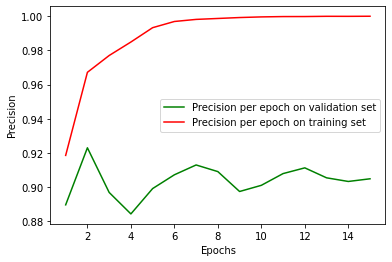

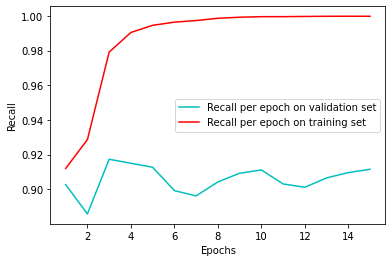

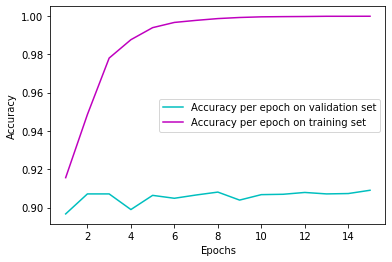

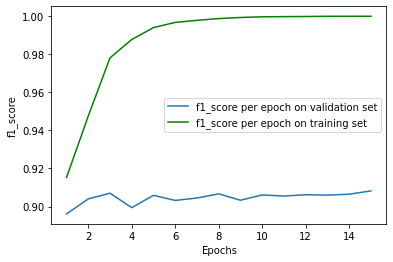

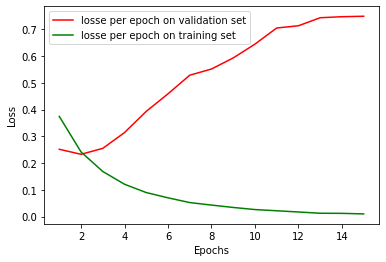

In [54]:
from pylab import *
import numpy as np
# Precision_Graph (validation set)
plot([x for x in range(1,epoch+1)], [x for x in precisions_validation], label="Precision per epoch on validation set", color="g")
plot([x for x in range(1,epoch+1)], [x for x in precisions_training], label="Precision per epoch on training set", color="r")
ylabel('Precision')
xlabel('Epochs')
legend()
show()

# recall_Graph
plot([x for x in range(1,epoch+1)], [x for x in recalls_validation], label="Recall per epoch on validation set", color="c")
plot([x for x in range(1,epoch+1)], [x for x in recalls_training], label="Recall per epoch on training set", color="r")
ylabel('Recall')
xlabel('Epochs')
legend()
show()

# accuracy_Graph
plot([x for x in range(1,epoch+1)], [x for x in accuracies_validation], label="Accuracy per epoch on validation set", color="c")
plot([x for x in range(1,epoch+1)], [x for x in accuracies_training], label="Accuracy per epoch on training set", color="m")
ylabel('Accuracy')
xlabel('Epochs')
legend()
show()

# f1_score_Graph
plot([x for x in range(1,epoch+1)], [x for x in f1_scores_validation], label="f1_score per epoch on validation set")
plot([x for x in range(1,epoch+1)], [x for x in f1_scores_training], label="f1_score per epoch on training set", color="g")
ylabel('f1_score')
xlabel('Epochs')
legend()
show()

# Losses_Graph
plot([x for x in range(1,epoch+1)], [x for x in validation_losses], label="losse per epoch on validation set", color="r")
plot([x for x in range(1,epoch+1)], [x for x in training_losses], label="losse per epoch on training set", color="g")
ylabel('Loss')
xlabel('Epochs')
legend()
show()



In [46]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [47]:
model.load_state_dict(torch.load('Models/finetuned_BERT_epoch_4.model', map_location=torch.device('cpu')))

<All keys matched successfully>

In [48]:
_, predictions, true_vals = evaluate(dataloader_validation)

In [49]:
accuracy_per_class(predictions, true_vals)

Class: not_entailment
Accuracy: 0.8833458364591148

Class: entailment
Accuracy: 0.915



In [50]:
precision_recall(predictions, true_vals)

              precision    recall  f1-score   support

           0       0.91      0.88      0.90      2666
           1       0.88      0.92      0.90      2600

    accuracy                           0.90      5266
   macro avg       0.90      0.90      0.90      5266
weighted avg       0.90      0.90      0.90      5266

Class: not_entailment

